# Data analysis
How many files are there in LibriSpeech splits for VoicePrivacy challenge?

In [2]:
%matplotlib inline
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt
import time

In [4]:
import torchaudio 
from speechbrain.dataio.preprocess import AudioNormalizer

base_dir = "../data/LibriSpeech"

def load_audio(path):
    signal, sr = torchaudio.load(path, channels_first=False)
    return AudioNormalizer()(signal, sr)

In [17]:
def count_audiofile_stats(split_name="test-clean"):
    all_speaker_audio_lens = []
    total_time = 0
    num_utterances = 0
    for speaker in Path(base_dir, split_name).iterdir():
        if not speaker.is_dir(): 
            continue 
        
        audio_lengths = []
        for session in speaker.iterdir():
            if not session.is_dir():
                continue 
            
            for utt in session.iterdir():
                if not str(utt).endswith("flac"):
                    continue 
                #print("Speaker: {}, session: {}, utterance: {}, filename: {}".format(speaker.name, session.name, utt.name, utt))

                signal, sr = torchaudio.load(str(utt), channels_first=False)
                #print("sr=", sr)  # 16k
                #print("signal.shape", signal.shape) # (N,1)
                audio_len = signal.size(0) / sr  # in seconds
                audio_lengths.append(audio_len)

                total_time += audio_len 
                num_utterances += 1
            
        speaker_avg_len = np.mean(audio_lengths)
        all_speaker_audio_lens.append(speaker_avg_len)

    print ("Speaker number: {}".format(len(all_speaker_audio_lens)))
    print ("There are {} utterances; up to {:.2f} hours".format(
        num_utterances, total_time / 3600.0))

    return all_speaker_audio_lens

Speaker number: 40
There are 2620 utterances; up to 5.40 hours


Text(0, 0.5, 'Occurrence')

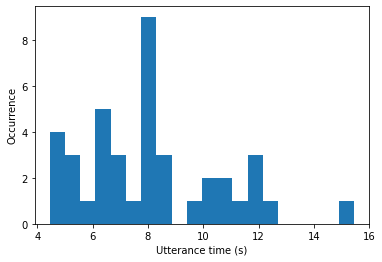

In [18]:
all_speaker_audio_lens = count_audiofile_stats("test-clean")  # 5.1s
plt.hist(all_speaker_audio_lens, bins=20)
plt.xlabel("Utterance time (s)")
plt.ylabel("Occurrence")

Speaker number: 40
There are 2703 utterances; up to 5.39 hours


Text(0, 0.5, 'Occurrence')

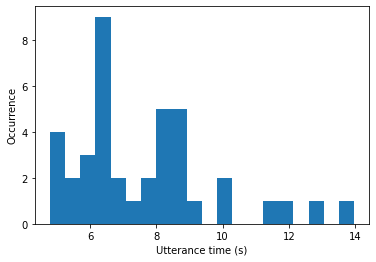

In [19]:
all_speaker_audio_lens = count_audiofile_stats("dev-clean")  # 5.1s
plt.hist(all_speaker_audio_lens, bins=20)
plt.xlabel("Utterance time (s)")
plt.ylabel("Occurrence")

Speaker number: 251
There are 28539 utterances; up to 100.59 hours


Text(0, 0.5, 'Occurrence')

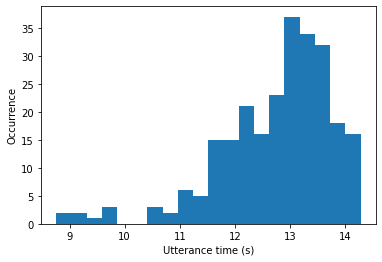

In [20]:
all_speaker_audio_lens = count_audiofile_stats("train-clean-100")  # 1 min 28.5s
plt.hist(all_speaker_audio_lens, bins=20)
plt.xlabel("Utterance time (s)")
plt.ylabel("Occurrence")

In [18]:
def count_audio_transcript_lengths_by_speaker(split_name="dev-clean-100"):
    audio_lens = []
    transcript_lens = []
    for speaker in sorted(Path(base_dir, split_name).iterdir()):
        if not speaker.is_dir():
            continue 
        speaker_audio_lens = []
        speaker_transcript_lens = []
        for sess in speaker.iterdir():
            if not sess.is_dir():
                continue 
            for f in sess.iterdir():
                if f.name.endswith(".txt"):
                    lines = f.read_text().split("\n")
                    for line in lines:
                        if len(line) > 0:
                            speaker_transcript_lens.append(len(line.split())-1)
                elif f.name.endswith(".flac"):
                    signal, sr = torchaudio.load(str(f), channels_first=False)
                    
                    audio_len = signal.size(0) / sr  # in seconds
                    speaker_audio_lens.append(audio_len)
                else:
                    continue 
        assert len(speaker_audio_lens) == len(speaker_transcript_lens)
        audio_lens.append(np.sum(speaker_audio_lens))
        transcript_lens.append(np.sum(speaker_transcript_lens))
    return audio_lens, transcript_lens

audio_lens, transcript_lens = count_audio_transcript_lengths_by_speaker("dev-clean")

In [19]:
np.mean(audio_lens), np.std(audio_lens)

(484.90301874999994, 4.7806117483351755)

In [20]:
np.mean(transcript_lens), np.std(transcript_lens)

(1360.05, 139.32515027804564)

/Users/zhuzi/miniforge3/envs/transformers4/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


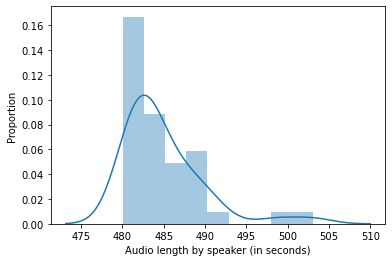

In [21]:
import seaborn as sns 

plt.figure()
sns.distplot(audio_lens)
plt.xlabel("Audio length by speaker (in seconds)")
plt.ylabel("Proportion")
plt.savefig("audio_distplot_by_speaker.svg")

/Users/zhuzi/miniforge3/envs/transformers4/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


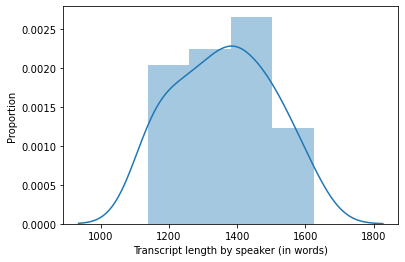

In [22]:
plt.figure()
sns.distplot(transcript_lens)
plt.xlabel("Transcript length by speaker (in words)")
plt.ylabel("Proportion")
plt.savefig("transcript_distplot_by_speaker.svg")